In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import powerlaw
import plotly.express as px

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

import keras_tuner as kt

from mlxtend.plotting import plot_decision_regions 

import warnings
warnings.filterwarnings('ignore')

In [167]:
df = pd.read_csv('airbnb.csv')
df.sample(2)

Unnamed: 0        id                                          name  \
4905        4905  52688544  Spending the night in connection with nature   
4302        4302  52343478         Maldives Luxury Yacht Private Charter   

     rating reviews host_name      host_id  \
4905    4.9      40    Simone  426499096.0   
4302    New       0       Ali   64588045.0   

                                  address  \
4905  Achterveld, Gelderland, Netherlands   
4302                 Malé, Male, Maldives   

                                        features  \
4905  4 guests,1 bedroom,2 beds,Toilet with sink   
4302  16 guests,10 bedrooms,20 beds,11 bathrooms   

                                              amenities  \
4905  Garden view,Kitchen,Wifi,Dedicated workspace,F...   
4302  Kitchen,Hot tub,TV,Air conditioning,Hair dryer...   

                                           safety_rules  \
4905  󹀁,Airbnb's COVID-19 safety practices apply,󱠃,M...   
4302  󹀁,Airbnb's COVID-19 safety practices apply,󱠃,N...   

                                           hourse_rules  \
4905  Check-in: After 3:00 pm,Check out: 12:00 pm,No...   
4302  Check-in: 1:00 pm - 6:00 pm,No pets,󱤇,Smoking ...   

                                              img_links   price  
4905  https://a0.muscache.com/im/pictures/miso/Hosti...    5528  
4302  https://a0.muscache.com/im/pictures/63901e76-2...  364821

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12805 entries, 0 to 12804
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    12805 non-null  int64  
 1   id            12805 non-null  int64  
 2   name          12805 non-null  object 
 3   rating        12805 non-null  object 
 4   reviews       12805 non-null  object 
 5   host_name     12797 non-null  object 
 6   host_id       12805 non-null  float64
 7   address       12805 non-null  object 
 8   features      12805 non-null  object 
 9   amenities     12805 non-null  object 
 10  safety_rules  12805 non-null  object 
 11  hourse_rules  12805 non-null  object 
 12  img_links     12805 non-null  object 
 13  price         12805 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 1.4+ MB


In [169]:
df.describe()

Unnamed: 0            id       host_id         price
count  12805.000000  1.280500e+04  1.280500e+04  1.280500e+04
mean    6402.000000  7.525187e+16  1.638192e+08  1.769780e+04
std     3696.629433  2.007933e+17  1.413622e+08  4.569364e+04
min        0.000000  1.313100e+04  2.303900e+04  3.930000e+02
25%     3201.000000  2.023958e+07  3.700032e+07  3.994000e+03
50%     6402.000000  3.682229e+07  1.256459e+08  8.175000e+03
75%     9603.000000  4.999760e+07  2.639623e+08  1.606200e+04
max    12804.000000  7.017905e+17  4.758973e+08  1.907963e+06

In [170]:
df.duplicated().sum()

0

In [171]:
df['features'].str.split(',').to_frame().sample(5)

features
4435     [10 guests, 5 bedrooms, 5 beds, 5 bathrooms]
11287   [4 guests, 2 bedrooms, 2 beds, 2.5 bathrooms]
12535     [5 guests, 2 bedrooms, 2 beds, 2 bathrooms]
1393   [12 guests, 3 bedrooms, 6 beds, 4.5 bathrooms]
11365     [6 guests, 2 bedrooms, 2 beds, 2 bathrooms]

Checked 9-10 times and found that the keyword used with no of guests is 'guests'.

In [172]:
def filter_by_guest_allowed(x):
    for item in x:
        if ('guests') in item:
            return int(item[0])
    else:
        return 0

In [173]:
df['guest_allowed'] = df['features'].str.split(',').apply(lambda x : filter_by_guest_allowed(x))
df.sample()

Unnamed: 0        id                                             name  \
10627       10627  18520005  Hollerhof - Native Paradise - Creative Holidays   

      rating reviews  host_name      host_id  \
10627   4.84      98  Charlotte  128554035.0   

                                     address  \
10627  Friedrichswalde, Brandenburg, Germany   

                                   features  \
10627  3 guests,1 bedroom,2 beds,1 bathroom   

                                               amenities  \
10627  Garden view,Lake access,Kitchen,Wifi,Free park...   

                                            safety_rules  \
10627  󹀁,Airbnb's COVID-19 safety practices apply,Car...   

                                            hourse_rules  \
10627  Check-in: 3:00 pm - 9:00 pm,Check out: 11:00 a...   

                                               img_links  price  guest_allowed  
10627  https://a0.muscache.com/im/pictures/ecb6b3d0-2...   5503              3

In [174]:
df['guest_allowed'].isnull().sum()

0

In [175]:
df['features'].str.split(',').to_frame().sample(5)

features
5417   [4 guests, 1 bedroom, 4 beds, 1.5 shared bathr...
7015                  [10 guests, 1 bedroom, 1 bathroom]
3821     [2 guests, 1 bedroom, 1 bed, 1 shared bathroom]
12228        [2 guests, 1 bedroom, 1 bed, 1.5 bathrooms]
6585         [4 guests, 2 bedrooms, 2 beds, 2 bathrooms]

Checked 9-10 times and found that the keywords that refers to no of bedrooms are 'bedroom' and 'bedrooms'

In [176]:
def filter_by_no_of_bedrooms(x):
    for item in x:
        if ('bedroom' or 'bedrooms') in item:
            return int(item[0])
    else:
        return 0 

In [177]:
df['No_of_bedrooms'] = df['features'].str.split(',').apply(lambda x : filter_by_no_of_bedrooms(x))
df.sample()

Unnamed: 0                  id  \
3178        3178  624500598745215918   

                                                  name rating reviews  \
3178  Rays & Haze - Entire attic villa w/ free parking    4.8       5   

     host_name      host_id                       address  \
3178     Pooja  458577721.0  Kurseong, West Bengal, India   

                                     features  \
3178  12 guests,5 bedrooms,5 beds,6 bathrooms   

                                              amenities  \
3178  Mountain view,Wifi,Dedicated workspace,Free pa...   

                                           safety_rules  \
3178  󹀁,Airbnb's COVID-19 safety practices apply,󱠃,N...   

                                           hourse_rules  \
3178  Check-in: After 11:00 am,Check out: 10:00 am,S...   

                                              img_links  price  guest_allowed  \
3178  https://a0.muscache.com/im/pictures/455ebe21-d...  13694              1   

      No_of_bedrooms  
3178               5

In [178]:
df['No_of_bedrooms'].isnull().sum()

0

In [179]:
df['features'].str.split(',').to_frame().sample(5)

features
9871        [2 guests, 1 bedroom, 1 bed, 1 bathroom]
4828       [5 guests, 1 bedroom, 5 beds, 1 bathroom]
11497  [5 guests, 3 bedrooms, 3 beds, 2.5 bathrooms]
12320    [5 guests, 2 bedrooms, 2 beds, 2 bathrooms]
2819     [7 guests, 2 bedrooms, 3 beds, 2 bathrooms]

Checked 9-10 times and found that the keywords that refers to no of beds are 'bed' and 'beds'

In [180]:
def filter_by_no_of_beds(x):
    for item in x:
        if ('bed' or 'beds') in item:
            return int(item[0])
    else: 
        return 0

In [181]:
df['No_of_beds'] = df['features'].str.split(',').apply(lambda x : filter_by_no_of_beds(x))
df.sample()

Unnamed: 0        id                                            name  \
5765        5765  53711595  Beautiful Private Island w/ Lakehouse - Anayad   

     rating reviews host_name     host_id                           address  \
5765    5.0      10   Maricar  24600795.0  Cavinti, Calabarzon, Philippines   

                                    features  \
5765  10 guests,3 bedrooms,2 beds,1 bathroom   

                                              amenities  \
5765  Lake view,Mountain view,Waterfront,Kitchen,Ded...   

                                           safety_rules  \
5765  󹀁,Airbnb's COVID-19 safety practices apply,󱠆,C...   

                                           hourse_rules  \
5765  Check-in: 2:00 pm - 6:00 pm,Check out: 11:00 a...   

                                              img_links  price  guest_allowed  \
5765  https://a0.muscache.com/im/pictures/f42bce98-1...  13079              1   

      No_of_bedrooms  No_of_beds  
5765               3           3

In [182]:
df['No_of_beds'].isnull().sum()

0

In [183]:
df['features'].str.split(',').to_frame().sample(5)

features
9684  [2 guests, 1 bedroom, 1 bed, 1 shared bathroom]
1536      [9 guests, 4 bedrooms, 4 beds, 5 bathrooms]
7284         [3 guests, 1 bedroom, 1 bed, 1 bathroom]
6388    [6 guests, 2 bedrooms, 4 beds, 1.5 bathrooms]
1906                    [2 guests, 1 bed, 1 bathroom]

Checked 20-30 times and found that the keywords that refers to no of bathrooms are 'bathroom', 'Toilet with sink', 'bathrooms', 'private bathroom', 'shared bathrooms', 'shared bathroom', 'Shared toilet with sink', 'Private toilet with sink', and 'shared baths'. 

In [184]:
def filter_by_no_of_bathrooms(x):
    for item in x:
        keywords = ('bathroom'or 'bathrooms' or 'private bathroom' or 'shared bathrooms' or 'shared bathroom')
        if keywords in item:
            return int(item[0])
        elif ('Shared toilet with sink') in item:
            return 1
        elif ('Toilet with sink') in item:
            return 1
        elif ('Private toilet with sink') in item:
            return 1
        elif ('shared baths') in item:
            return 1
    else:
        return 0

In [185]:
df['No of Bathrooms'] = df['features'].str.split(',').apply(lambda x : filter_by_no_of_bathrooms(x))
df.sample()

Unnamed: 0        id                                               name  \
5092        5092  31045289  Yellow Cube Cabin Stay@Lumut WIFI TV FREE PARKING   

     rating reviews host_name      host_id                        address  \
5092    5.0       5    Nasuha  186769498.0  Lumut, Negeri Perak, Malaysia   

                                          features  \
5092  5 guests,1 bedroom,3 beds,1 private bathroom   

                                              amenities  \
5092  Wifi,Free parking on premises,TV with standard...   

                                           safety_rules  \
5092  󹀁,Airbnb's COVID-19 safety practices apply,󱠆,C...   

                                           hourse_rules  \
5092  Check-in: 3:00 pm - 12:00 am,Check out: 12:00 ...   

                                              img_links  price  guest_allowed  \
5092  https://a0.muscache.com/im/pictures/be9d0ed4-e...   3469              5   

      No_of_bedrooms  No_of_beds  No of Bathrooms  
5092               1           1                1

In [186]:
df['No of Bathrooms'].isnull().sum()

0

In [187]:
df['amenities'].str.strip().to_frame().sample(5)

amenities
2357  Wifi,Shared hot tub,TV,Breakfast,Smoking allow...
8845  Kitchen,Wifi,Dedicated workspace,Free parking ...
7651  Kitchen,Wifi,Free parking on premises,TV with ...
6637  Lake access,Kitchen,Free parking on premises,T...
4985  Kitchen,Free parking on premises,Garden,Childr...

In [188]:
# Extracting unique amenities in 'amenities' column
amenities = []
for x in df['amenities'].str.split(','):
    for item in x:
        if item not in amenities:
            amenities.append(item)

amenities.sort()
amenities

[' 2–5 years old',
 ' 2–5 years old and 5–10 years old',
 ' 5–10 years old and 10+ years old',
 ' Amazon Prime Video',
 ' Apple TV',
 ' Chromecast',
 ' DVD player',
 ' Disney+',
 ' Fire TV',
 ' HBO Max',
 ' Hulu',
 ' Netflix',
 ' Roku',
 ' cable/satellite TV',
 ' gas powered fridge. refrigerator',
 ' heated',
 ' infinity',
 ' lap pool',
 ' olympic-sized',
 ' open 24 hours',
 ' open specific hours',
 ' rooftop',
 ' saltwater',
 ' standard cable/satellite',
 ' sun loungers',
 ' wood-burning',
 '100" HDTV with Amazon Prime Video',
 '100" TV',
 '100" TV with Chromecast',
 '100" TV with Netflix',
 '101" HDTV with HBO Max',
 '107" HDTV with standard cable/satellite',
 '108" HDTV with standard cable/satellite',
 '12" TV with Amazon Prime Video',
 '12" TV with Netflix',
 '12" TV with standard cable/satellite',
 '12v cool box refrigerator',
 '14" HDTV with cable/satellite TV',
 '14" TV',
 '15" TV',
 '15" TV with standard cable/satellite',
 '16" TV',
 '165" HDTV with cable/satellite TV',
 '17" T

In [189]:
def filter_by_keyword(x, keyword):
    for item in x:
        for key in keyword:
            if key in (item.lower()).split():
                return 1
    else :
        return 0

In [190]:
df['Wi-Fi Available'] = df['amenities'].str.split(',').apply(lambda x : filter_by_keyword(x, ['wifi']))
df.sample()

Unnamed: 0        id               name rating reviews host_name  \
8541        8541  28933518  Chalet Hausberger    5.0     106     Tanja   

          host_id                       address  \
8541  218092418.0  Mörtschach, Kärnten, Austria   

                                   features  \
8541  6 guests,2 bedrooms,3 beds,1 bathroom   

                                              amenities  \
8541  Mountain view,Kitchen,Wifi,Dedicated workspace...   

                                           safety_rules  \
8541  󹀁,Airbnb's COVID-19 safety practices apply,Car...   

                                           hourse_rules  \
8541  Check out: 10:00 am,Self check-in with lockbox...   

                                              img_links  price  guest_allowed  \
8541  https://a0.muscache.com/im/pictures/ff7dfbf1-a...   7803              6   

      No_of_bedrooms  No_of_beds  No of Bathrooms  Wi-Fi Available  
8541               2           2                1                1

In [191]:
df['Television Available'] = df['amenities'].str.split(',').apply(lambda x : filter_by_keyword(x, ['tv', 'hdtv']))
df.sample()

Unnamed: 0        id                              name rating reviews  \
2087        2087  45793819  Orchard Huts - Shepherds Delight   4.96     125   

     host_name     host_id                              address  \
2087     Emily  90196977.0  Winchcombe, England, United Kingdom   

                                 features  \
2087  2 guests,1 bedroom,1 bed,1 bathroom   

                                              amenities  \
2087  Kitchen,Free parking on premises,Private hot t...   

                                           safety_rules  \
2087  󹀁,Airbnb's COVID-19 safety practices apply,󱠃,P...   

                                           hourse_rules  \
2087  Check-in: After 3:00 pm,Check out: 10:00 am,Se...   

                                              img_links  price  guest_allowed  \
2087  https://a0.muscache.com/im/pictures/6f97542a-9...  16222              2   

      No_of_bedrooms  No_of_beds  No of Bathrooms  Wi-Fi Available  \
2087               1           1                1                0   

      Television Available  
2087                     0

In [192]:
df['Refrigerator Available'] = df['amenities'].str.split(',').apply(lambda x : filter_by_keyword(x, ['refrigerator']))
df.sample()

Unnamed: 0        id                    name rating reviews host_name  \
8622        8622  10642966  Modern robinson "Nane"   4.95      64     Danko   

         host_id                                            address  \
8622  54946177.0  Vela Luka, Dubrovačko-neretvanska županija, Cr...   

                                  features  \
8622  4 guests,1 bedroom,2 beds,1 bathroom   

                                              amenities  ...  \
8622  Bay view,Canal view,Beach access – Beachfront,...  ...   

                                           hourse_rules  \
8622  Not suitable for infants (under 2 years),No pe...   

                                              img_links price  guest_allowed  \
8622  https://a0.muscache.com/im/pictures/4d8393c9-6...  5603              4   

      No_of_bedrooms  No_of_beds  No of Bathrooms  Wi-Fi Available  \
8622               1           1                1                1   

      Television Available  Refrigerator Available  
8622                     0                       0  

[1 rows x 21 columns]

In [193]:
df['Scenic Views'] = df['amenities'].str.split(',').apply(lambda x : filter_by_keyword(x, ['view']))
df.sample()

Unnamed: 0       id                                            name  \
8675        8675  9856760  Island Hvar,Robinson vacation house Skozanje 1   

     rating reviews host_name     host_id  \
8675   4.63       8    Dijana  50387634.0   

                                    address  \
8675  Gdinj, Split-Dalmatia County, Croatia   

                                    features  \
8675  4 guests,1 bedroom,1 bed,1.5 bathrooms   

                                              amenities  ...  \
8675  Bay view,Canal view,Beach access – Beachfront,...  ...   

                                              img_links price guest_allowed  \
8675  https://a0.muscache.com/im/pictures/ffb01e4b-0...  6178             4   

      No_of_bedrooms  No_of_beds  No of Bathrooms  Wi-Fi Available  \
8675               1           1                1                1   

      Television Available  Refrigerator Available  Scenic Views  
8675                     0                       0             1  

[1 rows x 22 columns]

In [194]:
df['Parking Available'] = df['amenities'].str.split(',').apply(lambda x : filter_by_keyword(x, ['carport', 'parking', 'park', 'garage']))
df.sample()

Unnamed: 0        id                                 name rating  \
2385        2385  43137202  Villa Helmi - floating luxury villa    New   

     reviews host_name      host_id         address  \
2385       2     Pekka  343411405.0  Espoo, Finland   

                                    features  \
2385  4 guests,2 bedrooms,2 beds,2 bathrooms   

                                              amenities  ...  price  \
2385  Kitchen,Free parking on premises,Pets allowed,...  ...  42236   

     guest_allowed No_of_bedrooms  No_of_beds  No of Bathrooms  \
2385             4              2           2                2   

      Wi-Fi Available  Television Available  Refrigerator Available  \
2385                0                     1                       0   

      Scenic Views  Parking Available  
2385             0                  1  

[1 rows x 23 columns]

In [195]:
df['Pool Available'] = df['amenities'].str.split(',').apply(lambda x : filter_by_keyword(x, ['pool']))
df.sample()

Unnamed: 0        id   name rating reviews host_name      host_id  \
6543        6543  19471239  @home   4.76     108      Ravi  136606254.0   

                           address                                features  \
6543  Nainital, Uttarakhand, India  4 guests,2 bedrooms,3 beds,2 bathrooms   

                                              amenities  ... guest_allowed  \
6543  Mountain view,Valley view,Lake access,Kitchen,...  ...             4   

     No_of_bedrooms No_of_beds  No of Bathrooms  Wi-Fi Available  \
6543              2          2                2                1   

      Television Available  Refrigerator Available  Scenic Views  \
6543                     1                       0             1   

      Parking Available  Pool Available  
6543                  1               0  

[1 rows x 24 columns]

In [196]:
# Extracting unique safety_rules in 'amenities' column
safety_rules = []
for x in df['safety_rules'].str.split(','):
    for item in x:
        if item not in safety_rules:
            safety_rules.append(item)

safety_rules.sort()
safety_rules

['',
 ' other body of water',
 ' river',
 "Airbnb's COVID-19 safety practices apply",
 'Carbon monoxide alarm',
 'Carbon monoxide alarm not reported Show more',
 'Carbon monoxide detector not required Show more',
 'Climbing or play structure',
 'Heights without rails or protection',
 'May encounter potentially dangerous animals',
 'Nearby lake',
 'No carbon monoxide alarm',
 'No smoke alarm',
 'Not Available',
 'Pool/hot tub without a gate or lock',
 'Security camera/recording device Show more',
 'Show more',
 'Smoke alarm',
 'Smoke alarm not reported Show more',
 '\U000f1801',
 '\U000f1803',
 '\U000f1806',
 '\U000f9001']

Nothing much to extract from this feature and hence leaving this column.

In [197]:
# Extracting unique house_rules in 'amenities' column
house_rules = []
for x in df['hourse_rules'].str.split(','):
    for item in x:
        if item not in house_rules:
            house_rules.append(item)

house_rules.sort()
house_rules

['',
 'Check out: 10:00 am',
 'Check out: 10:00 pm',
 'Check out: 11:00 am',
 'Check out: 11:00 pm',
 'Check out: 12:00 am',
 'Check out: 12:00 pm',
 'Check out: 1:00 am',
 'Check out: 1:00 pm',
 'Check out: 2:00 am',
 'Check out: 2:00 pm',
 'Check out: 3:00 am',
 'Check out: 3:00 pm',
 'Check out: 4:00 am',
 'Check out: 4:00 pm',
 'Check out: 5:00 pm',
 'Check out: 6:00 pm',
 'Check out: 7:00 am',
 'Check out: 7:00 pm',
 'Check out: 8:00 am',
 'Check out: 8:00 pm',
 'Check out: 9:00 am',
 'Check-in: 10:00 am - 10:00 pm',
 'Check-in: 10:00 am - 11:00 pm',
 'Check-in: 10:00 am - 12:00 am',
 'Check-in: 10:00 am - 12:00 pm',
 'Check-in: 10:00 am - 1:00 am',
 'Check-in: 10:00 am - 1:00 pm',
 'Check-in: 10:00 am - 2:00 pm',
 'Check-in: 10:00 am - 3:00 pm',
 'Check-in: 10:00 am - 4:00 pm',
 'Check-in: 10:00 am - 5:00 pm',
 'Check-in: 10:00 am - 6:00 pm',
 'Check-in: 10:00 am - 7:00 pm',
 'Check-in: 10:00 am - 8:00 pm',
 'Check-in: 10:00 am - 9:00 pm',
 'Check-in: 10:00 pm - 12:00 am',
 'Chec

Nothing much to extract from this feature and hence leaving this column.

In [198]:
df['address'].sample(4)

11811    Merzouga, Drâa-Tafilalet, Morocco
10128               Santiago de Cuba, Cuba
3190               New Delhi, Delhi, India
10081                       Camagüey, Cuba
Name: address, dtype: object

Nothing important in this column and hence leaving this column.

In [199]:
df.sample()

Unnamed: 0        id                                         name  \
5217        5217  33976700  KeCabin, a modernity in a Malaysian Village   

     rating reviews host_name      host_id                          address  \
5217    New       1     Affan  256563767.0  Semabok Dalam, Melaka, Malaysia   

                                       features  \
5217  4 guests,Studio,2 beds,1 private bathroom   

                                              amenities  ... guest_allowed  \
5217  Wifi,Free parking on premises,Shared pool,TV,A...  ...             4   

     No_of_bedrooms No_of_beds  No of Bathrooms  Wi-Fi Available  \
5217              0          2                1                1   

      Television Available  Refrigerator Available  Scenic Views  \
5217                     1                       0             0   

      Parking Available  Pool Available  
5217                  1               1  

[1 rows x 24 columns]

In [200]:
final_df = df.drop(['Unnamed: 0', 'id', 'name', 'host_name', 'host_id', 'address',
                    'features', 'amenities', 'safety_rules', 'hourse_rules', 'img_links'], axis=1)

final_df.sample(2)

rating reviews  price  guest_allowed  No_of_bedrooms  No_of_beds  \
2853    New       0  11942              4               2           2   
1971   4.76      63   4608              4               1           1   

      No of Bathrooms  Wi-Fi Available  Television Available  \
2853                2                1                     1   
1971                1                0                     0   

      Refrigerator Available  Scenic Views  Parking Available  Pool Available  
2853                       0             0                  1               1  
1971                       0             0                  1               1

In [201]:
final_df['rating'] = final_df['rating'][final_df['rating'] != "New"].astype('float64');

In [202]:
def filter_ratings(x):
    if x > 4.5:
        return 5
    elif x > 4 and x <= 4.5:
        return 4
    elif x > 3.5 and x <= 4:
        return 3
    elif x > 3 and x <= 3.5:
        return 2
    elif x <= 3:
        return 1 

In [203]:
final_df['rating'].describe()

count    8567.000000
mean        4.857475
std         0.140803
min         3.000000
25%         4.770000
50%         4.890000
75%         4.980000
max         5.000000
Name: rating, dtype: float64

In [204]:
final_df['rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 12805 entries, 0 to 12804
Series name: rating
Non-Null Count  Dtype  
--------------  -----  
8567 non-null   float64
dtypes: float64(1)
memory usage: 100.2 KB


In [205]:
final_df['reviews'].unique();

- While converting this column to int, there is a problem with only one value, i.e., "1,003" and hence coverted it to "1003" and then will convert it to "int"

In [206]:
final_df['reviews'] = np.where(final_df['reviews'] == '1,003', '1003', final_df['reviews'])

In [207]:
final_df['reviews'].unique();

In [208]:
final_df['reviews'] = final_df['reviews'].astype('int64')

In [209]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12805 entries, 0 to 12804
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rating                  8567 non-null   float64
 1   reviews                 12805 non-null  int64  
 2   price                   12805 non-null  int64  
 3   guest_allowed           12805 non-null  int64  
 4   No_of_bedrooms          12805 non-null  int64  
 5   No_of_beds              12805 non-null  int64  
 6   No of Bathrooms         12805 non-null  int64  
 7   Wi-Fi Available         12805 non-null  int64  
 8   Television Available    12805 non-null  int64  
 9   Refrigerator Available  12805 non-null  int64  
 10  Scenic Views            12805 non-null  int64  
 11  Parking Available       12805 non-null  int64  
 12  Pool Available          12805 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 1.3 MB


<h2>Explorartory Data Analysis<h2>

<h4>1. Univariate Analysis on Numeric Column<h4>

**1.1. Prices Column**

In [210]:
final_df['price'].describe()

count    1.280500e+04
mean     1.769780e+04
std      4.569364e+04
min      3.930000e+02
25%      3.994000e+03
50%      8.175000e+03
75%      1.606200e+04
max      1.907963e+06
Name: price, dtype: float64

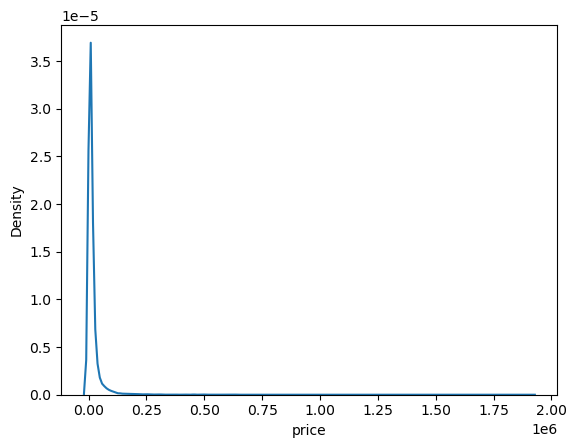

In [211]:
sns.kdeplot(final_df, x = 'price')
plt.show()

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


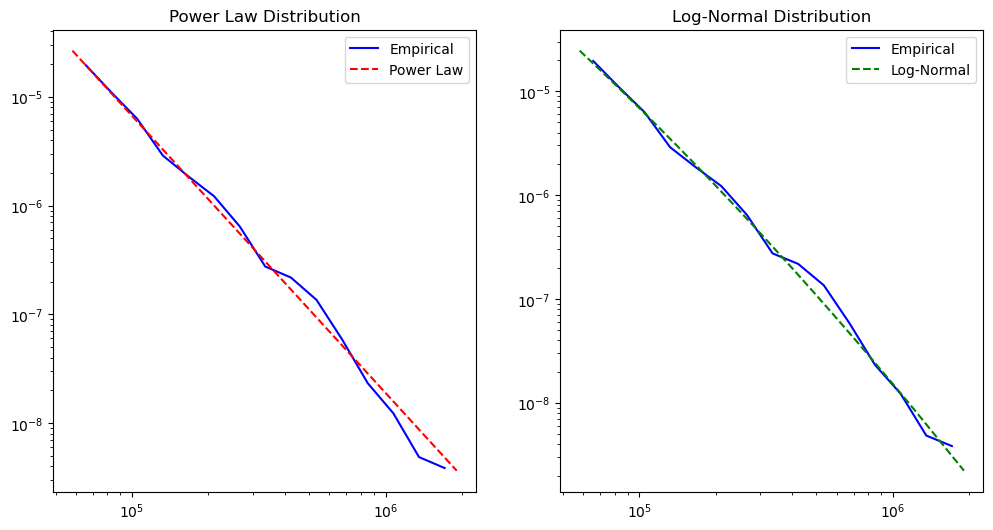

Likelihood ratio: -1.75232513803161, p-value: 0.23205332197521644


In [212]:
data = final_df['price']

fit_powerlaw = powerlaw.Fit(data)
fit_lognormal = powerlaw.Fit(data, distribution='lognormal')

# Plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

fit_powerlaw.plot_pdf(ax=ax[0], color='b', label='Empirical')
fit_powerlaw.power_law.plot_pdf(ax=ax[0], color='r', linestyle='--', label='Power Law')
ax[0].set_title('Power Law Distribution')
ax[0].legend()

fit_lognormal.plot_pdf(ax=ax[1], color='b', label='Empirical')
fit_lognormal.lognormal.plot_pdf(ax=ax[1], color='g', linestyle='--', label='Log-Normal')
ax[1].set_title('Log-Normal Distribution')
ax[1].legend()

plt.show()

R, p = fit_powerlaw.distribution_compare('power_law', 'lognormal')
print(f"Likelihood ratio: {R}, p-value: {p}")

- Since, Likelihood Ratio(R) = -1.75. Hence, it proves that the price column is more near to log normal distribution than power law distribution.

In [213]:
np.log(final_df['price']).describe()

count    12805.000000
mean         9.032687
std          1.107104
min          5.973810
25%          8.292549
50%          9.008836
75%          9.684212
max         14.461547
Name: price, dtype: float64

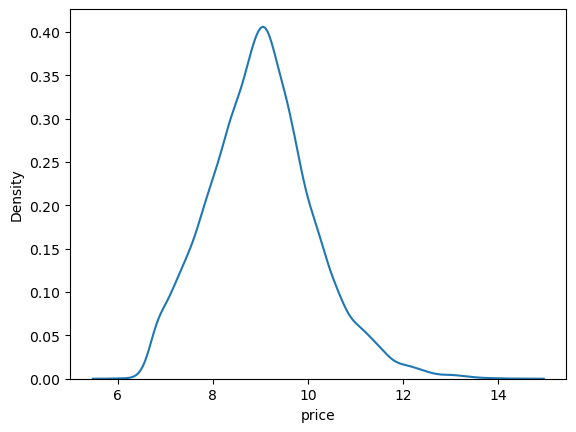

In [214]:
sns.kdeplot(final_df, x = np.log(final_df['price']))
plt.show()

In [215]:
px.box(final_df, x='price')

In [216]:
final_df[final_df['price'] < 393]

Empty DataFrame
Columns: [rating, reviews, price, guest_allowed, No_of_bedrooms, No_of_beds, No of Bathrooms, Wi-Fi Available, Television Available, Refrigerator Available, Scenic Views, Parking Available, Pool Available]
Index: []

In [217]:
final_df[final_df['price'] > 34151].sample(5)

rating  reviews   price  guest_allowed  No_of_bedrooms  No_of_beds  \
4518     NaN        0  243522              8               4           4   
3438    5.00        7   41612              6               3           3   
1327    5.00       50   59558              1               5           5   
1476    4.94       64   59643              2               1           1   
4436     NaN        0   62759              4               2           2   

      No of Bathrooms  Wi-Fi Available  Television Available  \
4518                4                0                     0   
3438                3                1                     1   
1327                4                1                     1   
1476                1                1                     1   
4436                1                1                     1   

      Refrigerator Available  Scenic Views  Parking Available  Pool Available  
4518                       1             0                  1               0  
3438                       0             0                  1               1  
1327                       0             0                  1               1  
1476                       0             0                  1               0  
4436                       0             1                  0               0

In [218]:
final_df['price'].isnull().sum()

0

1. **Observations**
    - The distribution of 'Prices' column is **Log-Normal Distribution**.
    - No missing values.
    - There are some outliers present.

**1.2. Rating Column**

In [219]:
final_df['rating'].describe()

count    8567.000000
mean        4.857475
std         0.140803
min         3.000000
25%         4.770000
50%         4.890000
75%         4.980000
max         5.000000
Name: rating, dtype: float64

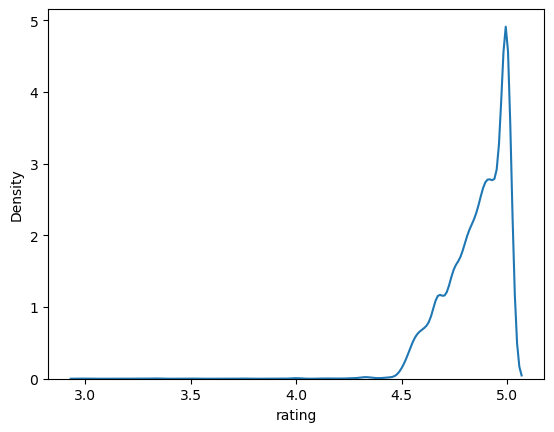

In [220]:
sns.kdeplot(final_df, x='rating')
plt.show()

In [221]:
final_df['rating'].skew()

-1.762801355120159

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


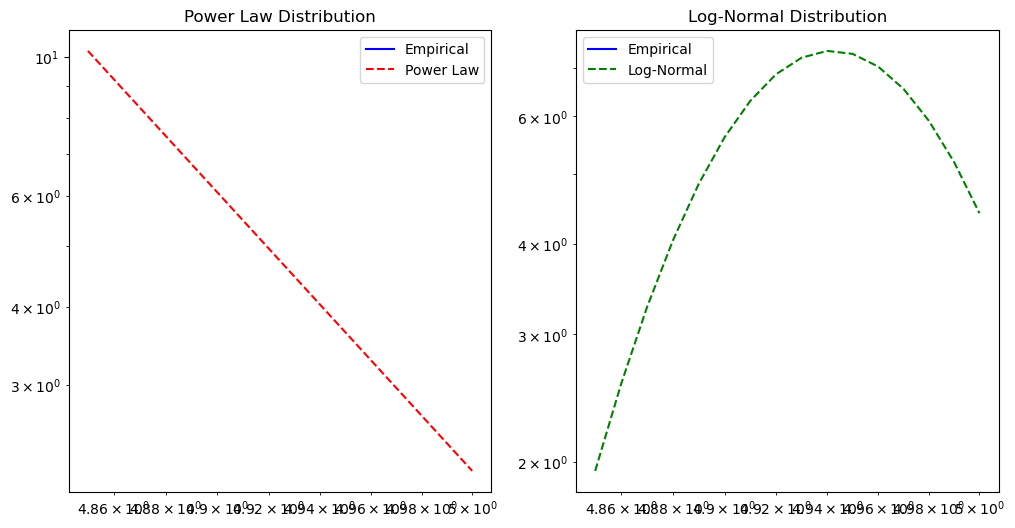

Likelihood ratio: -1477.4683520683736, p-value: 1.035394210942735e-198


In [222]:
data = final_df['rating'][final_df['rating'].notnull()]

fit_powerlaw = powerlaw.Fit(data)
fit_lognormal = powerlaw.Fit(data, distribution='lognormal')

# Plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

fit_powerlaw.plot_pdf(ax=ax[0], color='b', label='Empirical')
fit_powerlaw.power_law.plot_pdf(ax=ax[0], color='r', linestyle='--', label='Power Law')
ax[0].set_title('Power Law Distribution')
ax[0].legend()

fit_lognormal.plot_pdf(ax=ax[1], color='b', label='Empirical')
fit_lognormal.lognormal.plot_pdf(ax=ax[1], color='g', linestyle='--', label='Log-Normal')
ax[1].set_title('Log-Normal Distribution')
ax[1].legend()

plt.show()

R, p = fit_powerlaw.distribution_compare('power_law', 'lognormal')
print(f"Likelihood ratio: {R}, p-value: {p}")

- Negative likelihood ratio and a very small p-value confirms that log-normal distribution greatly fits our data(rating column)

In [223]:
px.box(final_df, x = 'rating')

In [224]:
len(final_df['rating'][final_df['rating'] < 4.46])

38

In [225]:
final_df['rating'].isnull().sum()

4238

- **Observations**
    - Rating column is highly(negatively) skewed with most values in range[4.5, 5]
    - There are missing values, which indicates that the listings are 'New' and have few or no bookings and the customers have not rated the listing(in case of few bookings).
    - Presence of some outliers.
    - The column has a **Log-Normal Distribution**

**1.3 Reviews Column**

In [226]:
final_df['reviews'].describe()

count    12805.000000
mean        36.140023
std         66.077810
min          0.000000
25%          1.000000
50%         10.000000
75%         42.000000
max       1003.000000
Name: reviews, dtype: float64

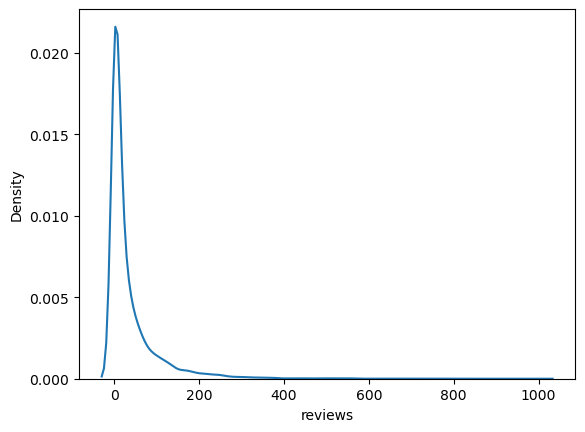

In [227]:
sns.kdeplot(final_df, x='reviews')
plt.show()

In [228]:
final_df['reviews'].isnull().sum()

0

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


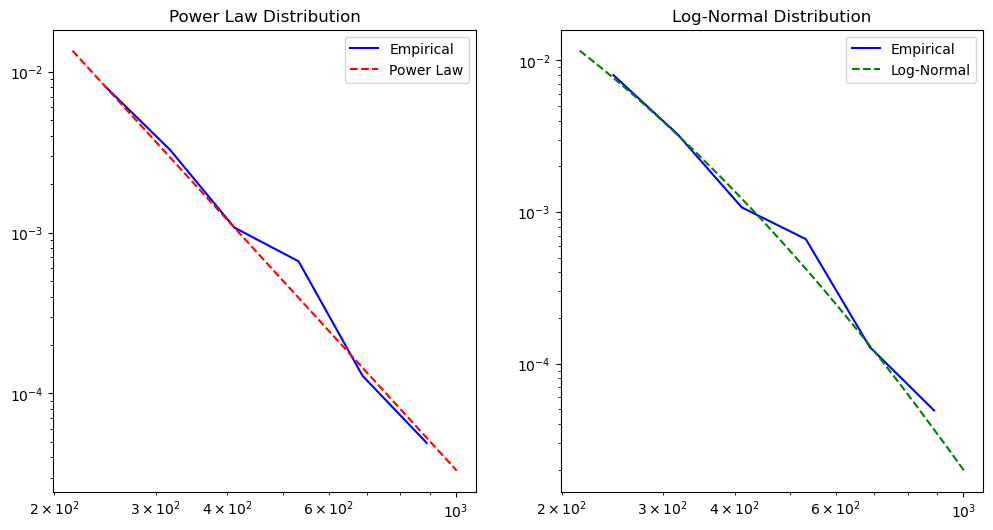

Likelihood ratio: -2.9221708419038244, p-value: 0.1158079035297632


In [229]:
data = final_df['reviews']

fit_powerlaw = powerlaw.Fit(data)
fit_lognormal = powerlaw.Fit(data, distribution='lognormal')

# Plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

fit_powerlaw.plot_pdf(ax=ax[0], color='b', label='Empirical')
fit_powerlaw.power_law.plot_pdf(ax=ax[0], color='r', linestyle='--', label='Power Law')
ax[0].set_title('Power Law Distribution')
ax[0].legend()

fit_lognormal.plot_pdf(ax=ax[1], color='b', label='Empirical')
fit_lognormal.lognormal.plot_pdf(ax=ax[1], color='g', linestyle='--', label='Log-Normal')
ax[1].set_title('Log-Normal Distribution')
ax[1].legend()

plt.show()

R, p = fit_powerlaw.distribution_compare('power_law', 'lognormal')
print(f"Likelihood ratio: {R}, p-value: {p}")

- Negative likelihood ratio proves that the reviews column is log-normal

In [230]:
px.box(final_df, x = 'reviews')

In [231]:
final_df[final_df['reviews'] < 0]

Empty DataFrame
Columns: [rating, reviews, price, guest_allowed, No_of_bedrooms, No_of_beds, No of Bathrooms, Wi-Fi Available, Television Available, Refrigerator Available, Scenic Views, Parking Available, Pool Available]
Index: []

In [232]:
final_df[final_df['reviews'] > 103]

rating  reviews  price  guest_allowed  No_of_bedrooms  No_of_beds  \
12       4.83      116  14612              8               2           2   
39       4.68      241  13010              9               3           3   
45       4.68      154   8767              1               3           3   
55       4.87      137   9028              4               1           1   
129      4.84      113   6165              4               1           1   
...       ...      ...    ...            ...             ...         ...   
12560    4.88      164  12146              4               1           1   
12716    4.89      114  11718              2               1           1   
12717    4.62      183  11582              2               1           1   
12735    4.83      272  12590              4               1           1   
12746    4.88      141  12894              5               1           1   

       No of Bathrooms  Wi-Fi Available  Television Available  \
12                   2                1                     0   
39                   1                1                     1   
45                   3                1                     1   
55                   1                1                     1   
129                  1                1                     1   
...                ...              ...                   ...   
12560                1                1                     0   
12716                1                1                     1   
12717                1                1                     0   
12735                1                1                     1   
12746                2                1                     1   

       Refrigerator Available  Scenic Views  Parking Available  Pool Available  
12                          1             0                  1               1  
39                          0             1                  1               0  
45                          0             1                  1               0  
55                          0             0                  1               0  
129                         0             1                  1               0  
...                       ...           ...                ...             ...  
12560                       0             0                  1               0  
12716                       0             1                  1               1  
12717                       0             0                  1               0  
12735                       0             1                  1               0  
12746                       0             1                  1               0  

[1284 rows x 13 columns]

- Most of no of reviews lies in range [0, 200].
- The distribution is **Log-Normal**.
- No Missing Values.
- Some outliers are present.

<h4>2. Univariate Analysis on categorical column<h4>

**2.1 'Guest_allowed' Column**

In [233]:
final_df['guest_allowed'].value_counts()

guest_allowed
2    3729
4    2607
1    1755
6    1471
3    1228
8     732
5     702
7     253
9     201
0     127
Name: count, dtype: int64

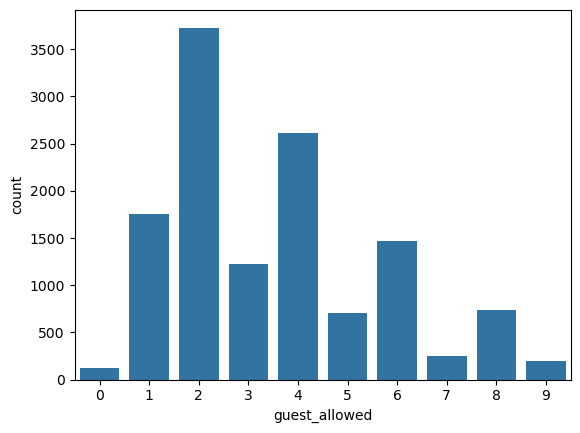

In [234]:
sns.countplot(final_df, x = 'guest_allowed');

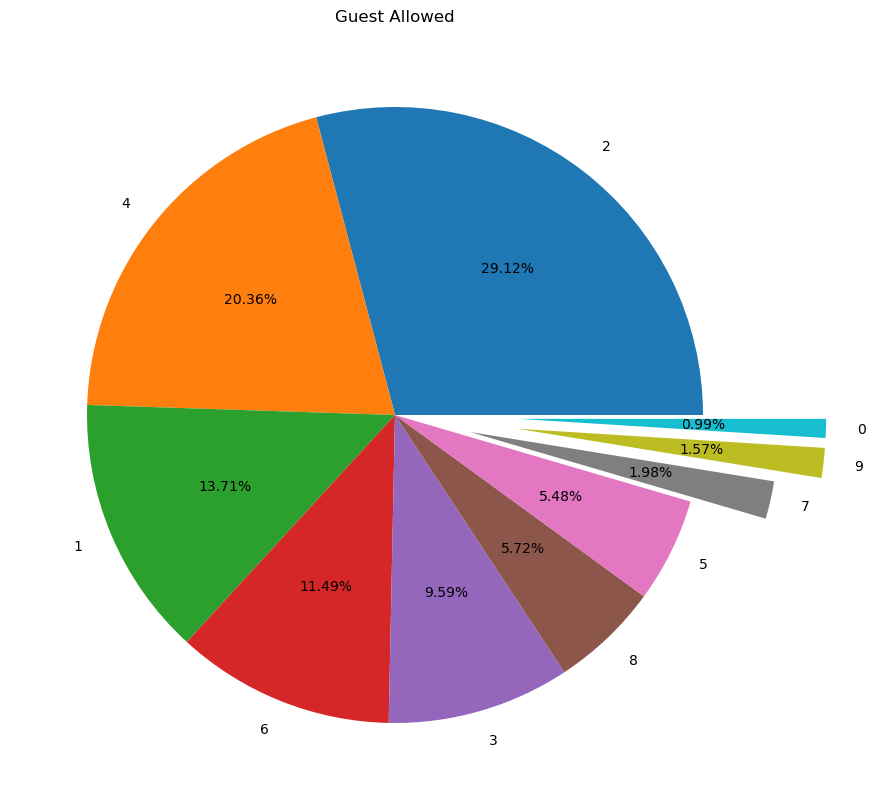

In [235]:
plt.figure(figsize=(15,10))
plt.title('Guest Allowed')
plt.pie(final_df['guest_allowed'].value_counts(), autopct='%0.2f%%', labels=final_df['guest_allowed'].value_counts().index, 
        explode=[0, 0, 0,0,0,0,0,0.25,0.4,0.4]);

In [236]:
final_df['guest_allowed'].isnull().sum()

0

- **Conclusions**
    - No missing values
    - 29.12% and 20.36% of all listings allow 2 and 4 guests, respectively.
    - 0.99% of all listings does not allow guests.

**2.2 'No. of Bedrooms' Column**

In [237]:
final_df['No_of_bedrooms'].value_counts()

No_of_bedrooms
1    6543
2    2407
3    1409
4     772
0     692
5     423
6     251
7     135
8     122
9      51
Name: count, dtype: int64

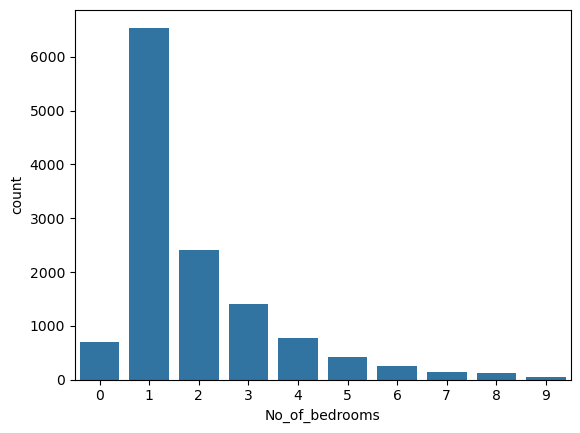

In [238]:
sns.countplot(final_df, x='No_of_bedrooms');

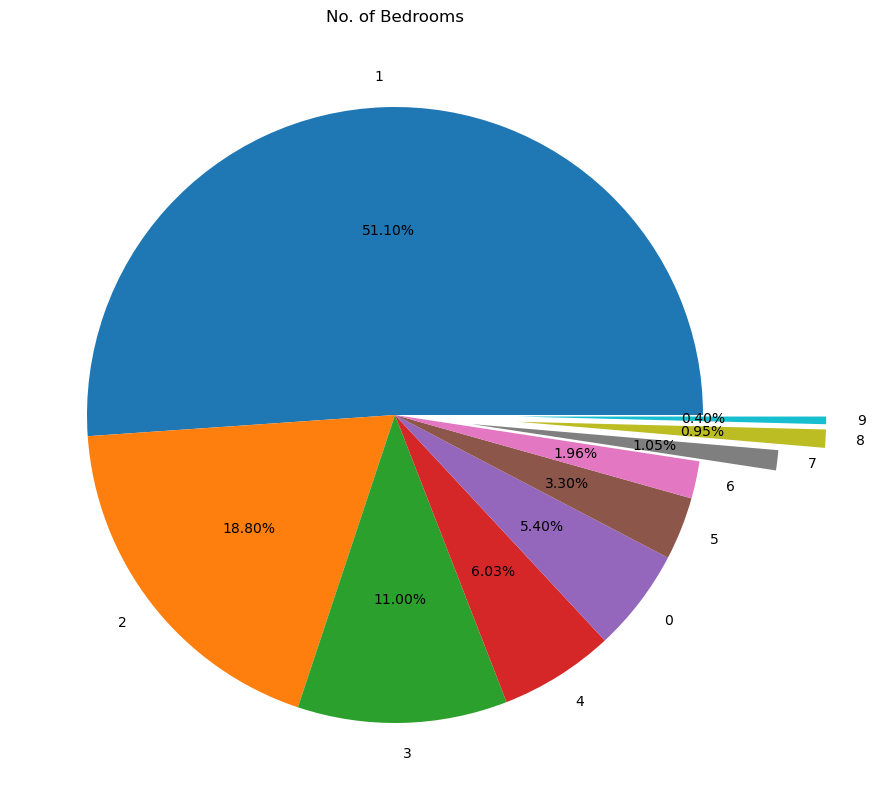

In [239]:
plt.figure(figsize=(15,10))
plt.title('No. of Bedrooms')
plt.pie(final_df['No_of_bedrooms'].value_counts(), autopct='%0.2f%%', labels=final_df['No_of_bedrooms'].value_counts().index, 
        explode=[0, 0, 0,0,0,0,0,0.25,0.4,0.4]);

In [240]:
final_df['No_of_bedrooms'].isnull().sum()

0

- **Conclusions**
    - No missing values.
    - 51.10% and 18.80% of all listings have 1 and 2 bedrooms, respectively.
    - 5.40% of all listings have no bedrooms, which can reduce the values of price of listing.  

**2.3 'No. of Beds' Column**

In [241]:
final_df['No_of_beds'].value_counts()

No_of_beds
1    6881
2    2578
3    1490
4     813
5     433
6     256
7     139
8     124
9      51
0      40
Name: count, dtype: int64

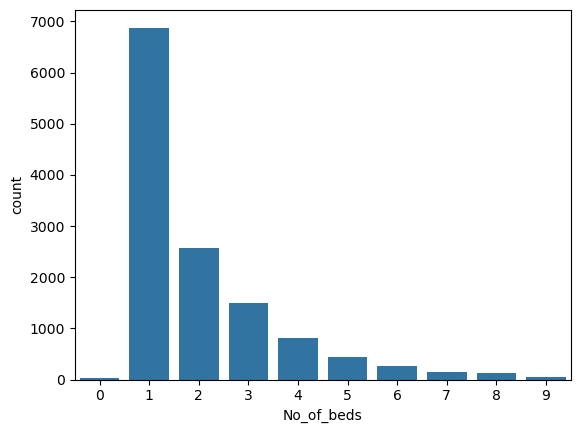

In [242]:
sns.countplot(final_df, x= 'No_of_beds')
plt.show()

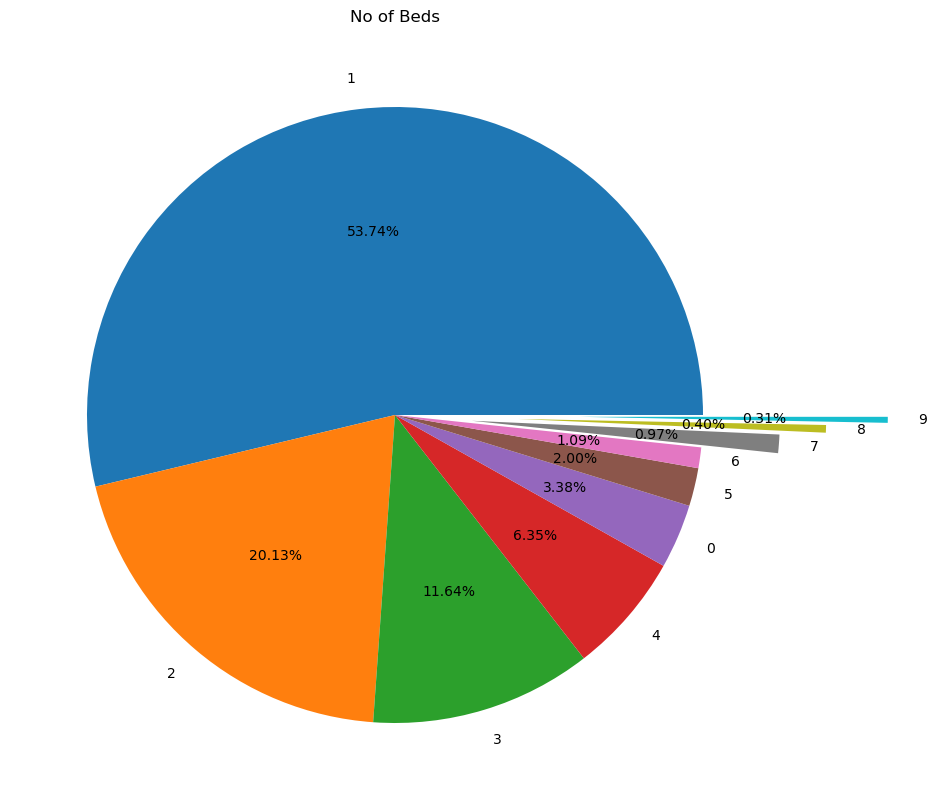

In [243]:
plt.figure(figsize=(15,10))
plt.title('No of Beds')
plt.pie(final_df['No_of_beds'].value_counts(), autopct='%0.2f%%', labels=final_df['No_of_bedrooms'].value_counts().index, 
        explode=[0, 0, 0,0,0,0,0,0.25,0.4,0.6])
plt.show()

In [244]:
final_df['No_of_beds'].isnull().sum()

0

- **Conclusions**
    - 53.74% and 20.13% of all listings have 1 and 2 beds, respectively.
    - 3.38% of all listings have 0 beds, which is not normal.
    - No missing values.

**2.4 'No of Bathrooms' Column**

In [245]:
final_df['No of Bathrooms'].value_counts()

No of Bathrooms
1    8379
2    1932
3     904
4     590
5     308
6     215
0     200
8     121
7     106
9      50
Name: count, dtype: int64

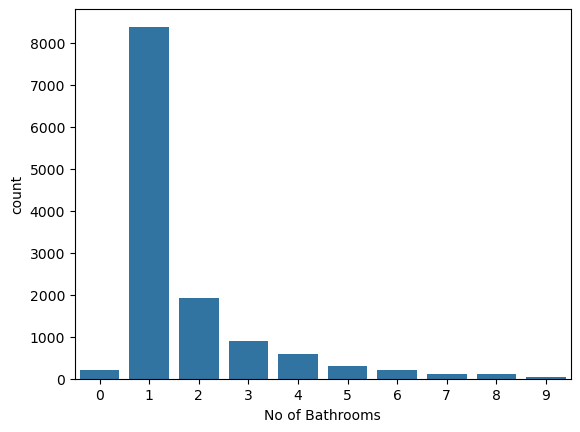

In [246]:
sns.countplot(final_df, x= 'No of Bathrooms')
plt.show()

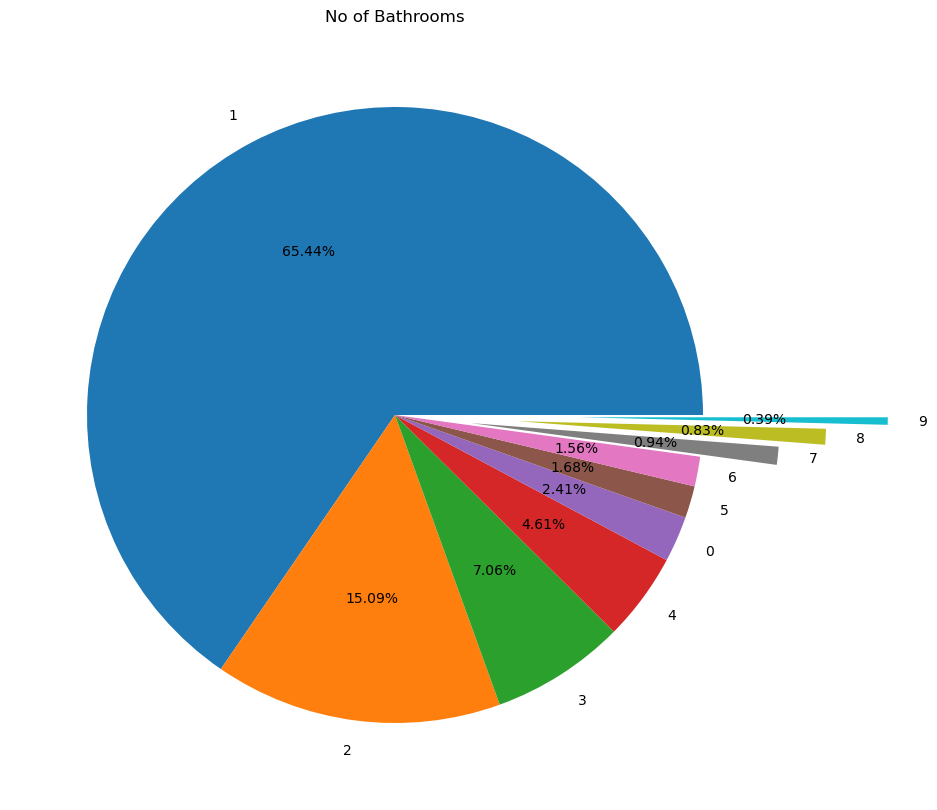

In [247]:
plt.figure(figsize=(15,10))
plt.title('No of Bathrooms')
plt.pie(final_df['No of Bathrooms'].value_counts(), autopct='%0.2f%%', labels=final_df['No_of_bedrooms'].value_counts().index, 
        explode=[0, 0, 0,0,0,0,0,0.25,0.4,0.6])
plt.show()

In [248]:
final_df['No of Bathrooms'].isnull().sum()

0

- **Conclusions**
    - No missing values.
    - 65.44% of all listings have 1 bathrooms.
    - 2.41% of all listings have no bathrooms.

**2.5 'Wi-Fi Available' Column**

In [249]:
final_df['Wi-Fi Available'].value_counts()

Wi-Fi Available
1    10300
0     2505
Name: count, dtype: int64

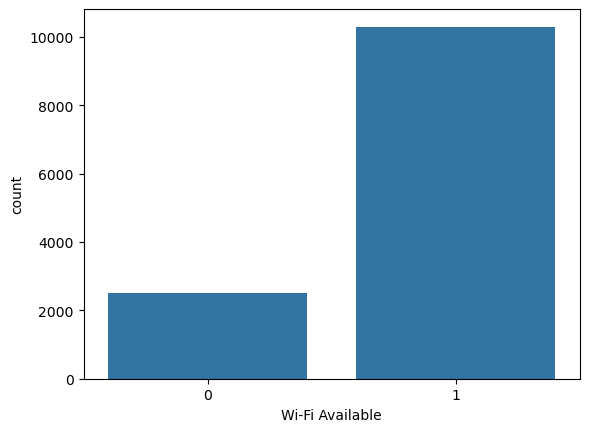

In [250]:
sns.countplot(final_df, x = 'Wi-Fi Available')
plt.show()

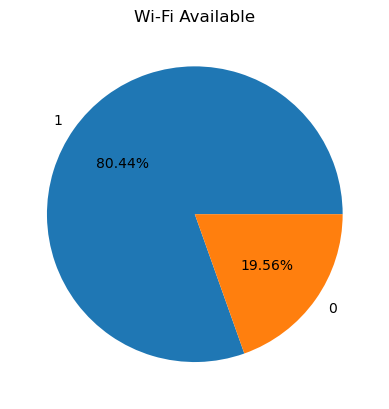

In [251]:
plt.title('Wi-Fi Available')
plt.pie(final_df['Wi-Fi Available'].value_counts(), autopct='%0.2f%%', labels=final_df['Wi-Fi Available']. value_counts().index)
plt.show()

In [252]:
final_df['Wi-Fi Available'].isnull().sum()

0

- **Conclusions**
    - No missing values.
    - 80.44% of all listings have Wi-Fi.
    - 19.56% of all listings have no Wi-Fi.

**2.6 'Television Available' Column**

In [253]:
final_df['Television Available'].value_counts()

Television Available
1    7521
0    5284
Name: count, dtype: int64

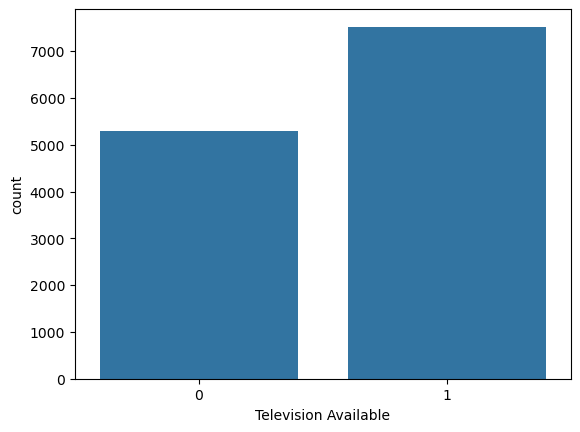

In [254]:
sns.countplot(final_df, x = 'Television Available')
plt.show()

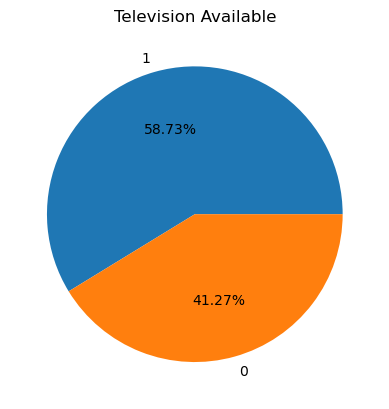

In [255]:
plt.title('Television Available')
plt.pie(final_df['Television Available'].value_counts(), labels=final_df['Television Available'].value_counts().index
        , autopct='%0.2f%%')
plt.show()

In [256]:
final_df['Television Available'].isnull().sum()

0

- **Conclusions**
    - No missing values.
    - 58.73% of all listings have television availability.
    - 41.27% of all listings have no television availability.

**2.7 'Refrigerator Available' Column** 

In [257]:
final_df['Refrigerator Available'].value_counts()

Refrigerator Available
0    11154
1     1651
Name: count, dtype: int64

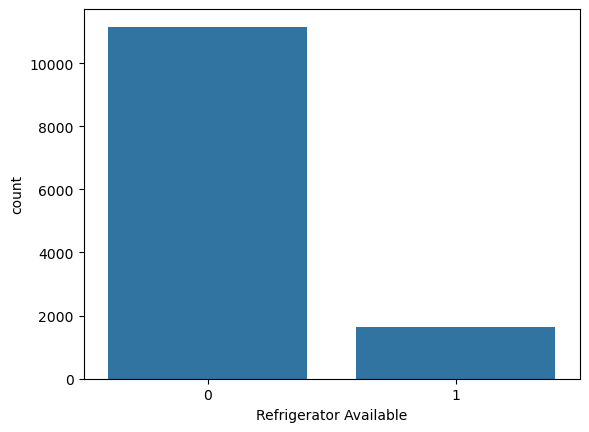

In [258]:
sns.countplot(final_df, x= 'Refrigerator Available')
plt.show()

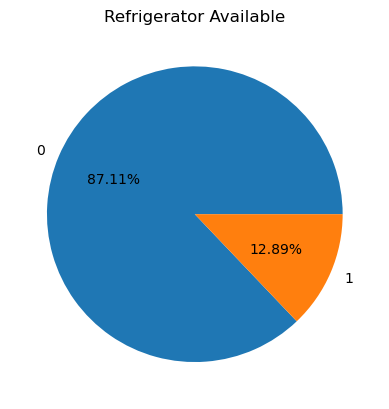

In [259]:
plt.title('Refrigerator Available')
plt.pie(final_df['Refrigerator Available'].value_counts(), labels=final_df['Refrigerator Available'].value_counts().index
        , autopct='%0.2f%%')
plt.show()

In [260]:
final_df['Refrigerator Available'].isnull().sum()

0

- **Conclusions**
    - No missing values.
    - 87.11% of all listings have no refrigerators.
    - 12.89% of all listings have refrigerators.

**2.8 'Scenic Views' Column**

In [261]:
final_df['Scenic Views'].value_counts()

Scenic Views
0    8201
1    4604
Name: count, dtype: int64

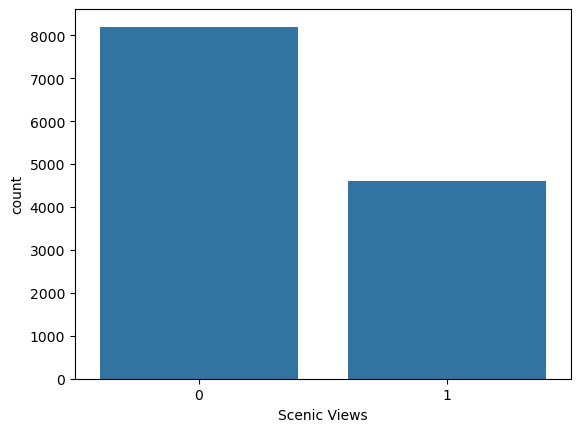

In [262]:
sns.countplot(final_df, x = 'Scenic Views')
plt.show()

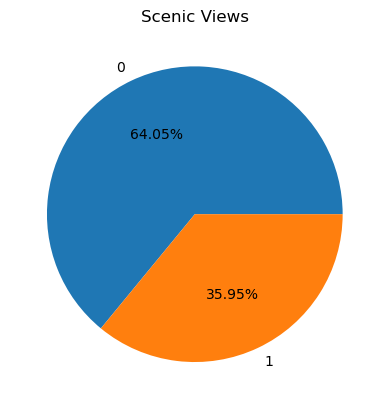

In [263]:
plt.title('Scenic Views')
plt.pie(final_df['Scenic Views'].value_counts(), labels=final_df['Scenic Views'].value_counts().index, autopct='%0.2f%%')
plt.show()

In [264]:
final_df['Scenic Views'].isnull().sum()

0

- **Conclusions**
    - No missing values.
    - 64.05% of all listings have no scenic views.
    - 35.95% of all listings have scenic views.

**2.9 'Parking Available' Column**

In [265]:
final_df['Parking Available'].value_counts()

Parking Available
1    10962
0     1843
Name: count, dtype: int64

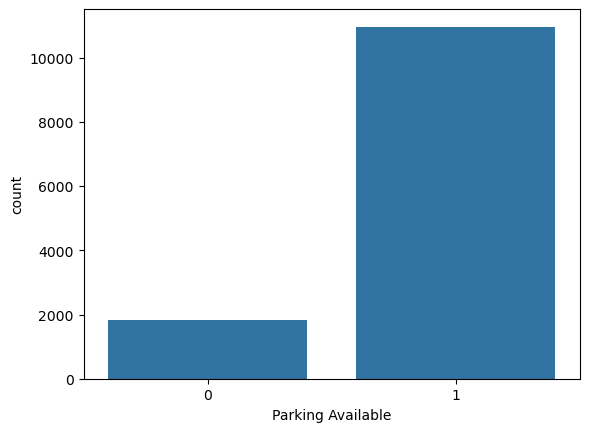

In [266]:
sns.countplot(final_df, x = 'Parking Available')
plt.show()

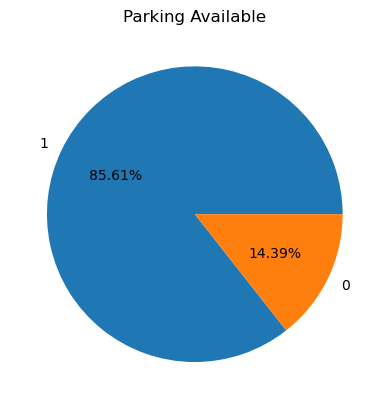

In [267]:
plt.title('Parking Available')
plt.pie(final_df['Parking Available'].value_counts(), labels=final_df['Parking Available'].value_counts().index, autopct='%0.2f%%')
plt.show()

In [268]:
final_df['Parking Available'].isnull().sum()

0

- **Conclusions**
    - No missing values.
    - 85.61% of all listings have parking.
    - 14.39% of all listings have no parking.

**2.10 'Pool Available' Column**

In [269]:
final_df['Pool Available'].value_counts()

Pool Available
0    9290
1    3515
Name: count, dtype: int64

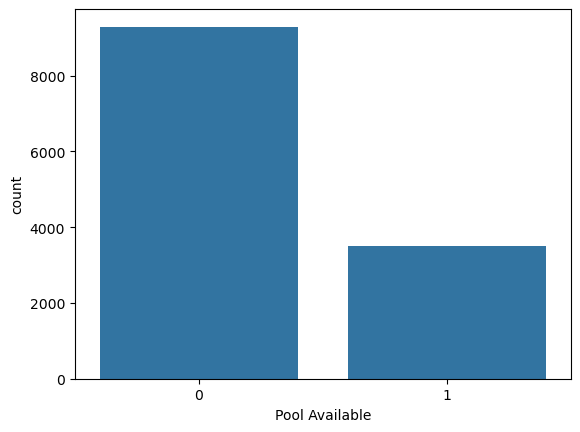

In [270]:
sns.countplot(final_df, x= 'Pool Available')
plt.show()

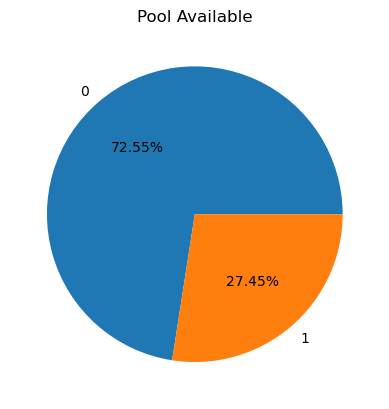

In [271]:
plt.title('Pool Available')
plt.pie(final_df['Pool Available'].value_counts(), labels=final_df['Pool Available'].value_counts().index, autopct='%0.2f%%')
plt.show()

In [272]:
final_df['Pool Available'].isnull().sum()

0

- **Conclusions**
    - No missing values.
    - 27.45% of all listings have pools.
    - 72.55% of all listings have no pools.

**3. Bivariate Analysis**

**3.1 'Ratings vs Price' Column**

In [273]:
px.scatter(final_df, x= 'price', y ='rating')

- **Conclusions**
    - Most of the datapoints are in the range where ratings is between 4.5 and 5.
    - There is no linear relationship of ratings with price column.

**3.2 Reviews vs Price** 

In [274]:
px.scatter(final_df, x = 'price', y = 'reviews')

- **Conclusions**
    - The graph shows no relation between reviews and price column.
    - The reviews for very costly listings are fewer than 2. This may be because their high price results in fewer bookings, and those who do book these listings may not leave reviews.

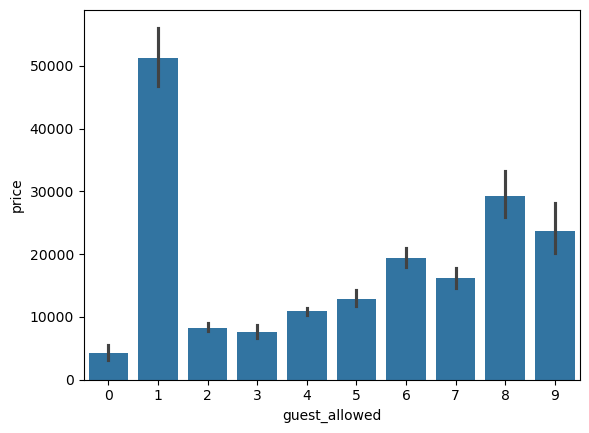

In [275]:
sns.barplot(final_df, y= 'price', x = 'guest_allowed')
plt.show()

- **Conclusions**
    - There is no apparent relationship between the guest_allowed and price columns.

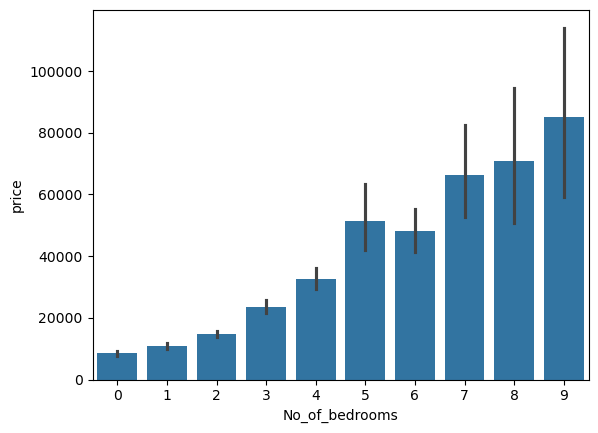

In [276]:
sns.barplot(final_df, y= 'price', x = 'No_of_bedrooms')
plt.show()

- **Conclusion**
    - As the number of bedrooms increases, the price of the listing also tends to increase.

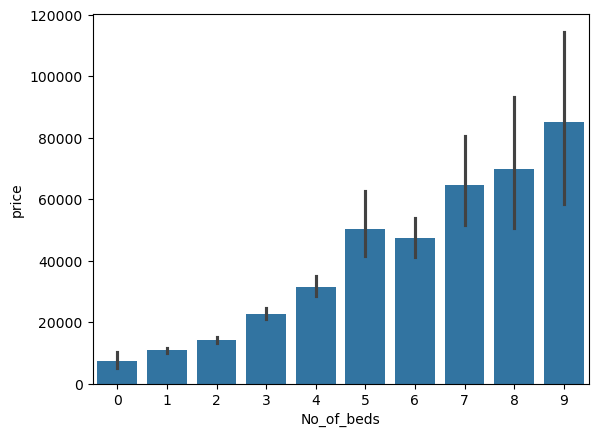

In [277]:
sns.barplot(final_df, x = 'No_of_beds', y = 'price')
plt.show()

- **Conclusion**
    - As the number of beds increases, the price of the listing also tends to increase.

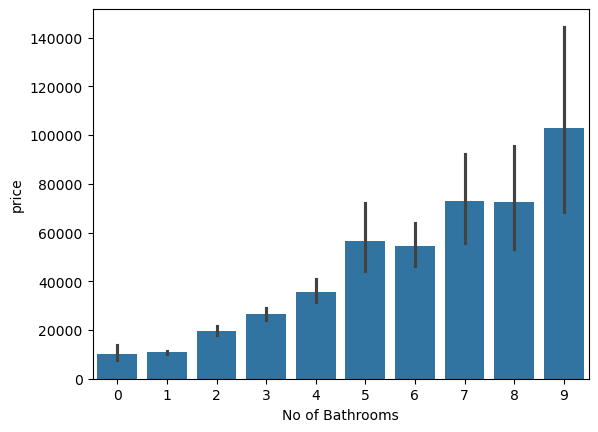

In [278]:
sns.barplot(final_df, y = 'price', x = 'No of Bathrooms')
plt.show()

- **Conclusions**
    - The price of the listings increase with increase in no of bathrooms.

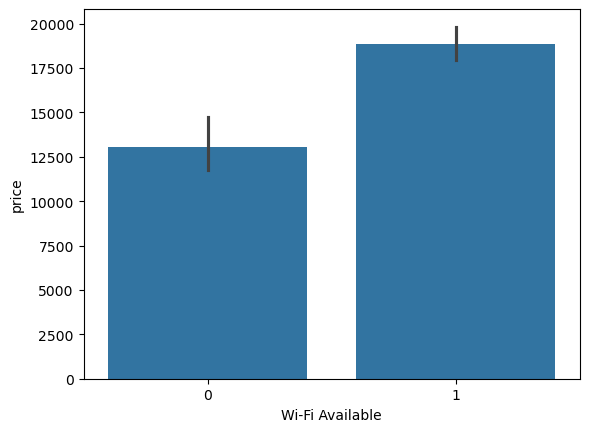

In [279]:
sns.barplot(final_df, y = 'price', x = 'Wi-Fi Available')
plt.show()

- **Conclusions**
    - The price of the listings is higher when Wi-Fi is available.

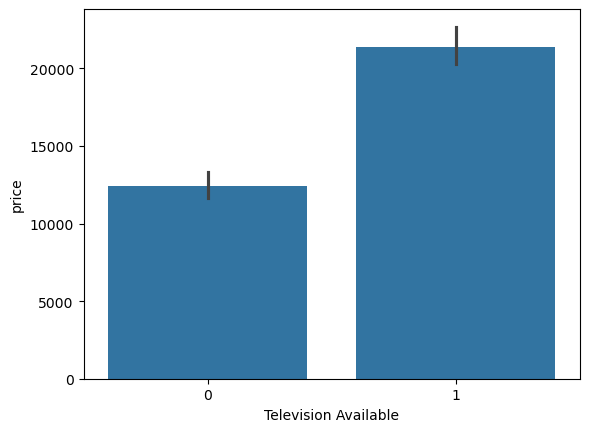

In [280]:
sns.barplot(final_df, y = 'price', x = 'Television Available')
plt.show()

- **Conclusions**
    - The price of the listings is higher when television is available.

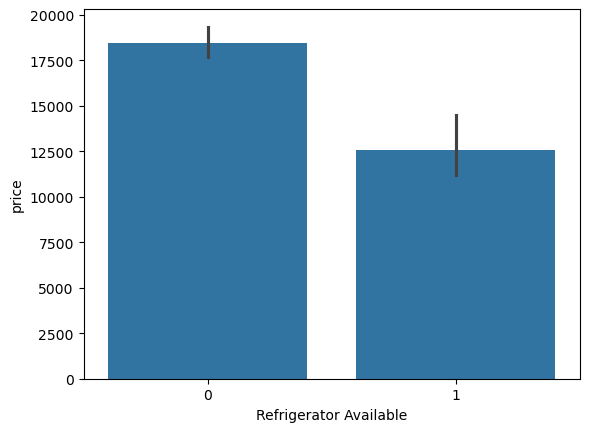

In [281]:
sns.barplot(final_df, y = 'price', x = 'Refrigerator Available')
plt.show()

- **Conclusions**
    - The price of the listings is higher when a refrigerator is not available, which is quite counterintuitive.

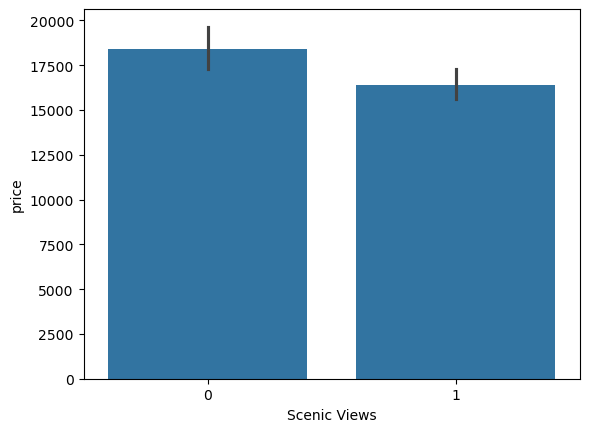

In [282]:
sns.barplot(final_df, y = 'price', x = 'Scenic Views')
plt.show()

- **Conclusions**
    - The price of listings does not vary much whether scenic views are present or absent, indicating that the price column does not heavily depend on the scenic view column. 

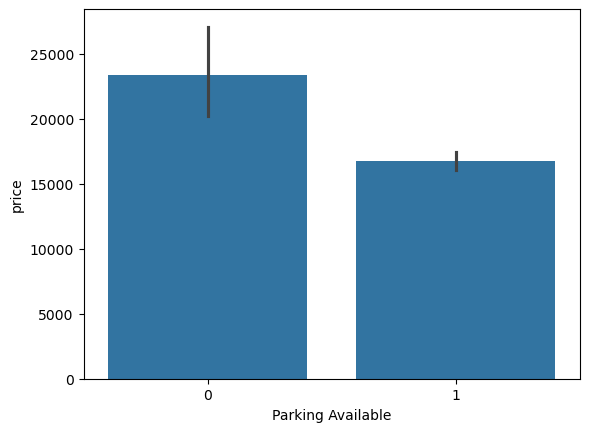

In [283]:
sns.barplot(final_df, y = 'price', x = 'Parking Available')
plt.show()

- **Conclusions**
    - The price of the listings does not show much variation based on parking availability, suggesting that parking availability does not significantly affect the price.

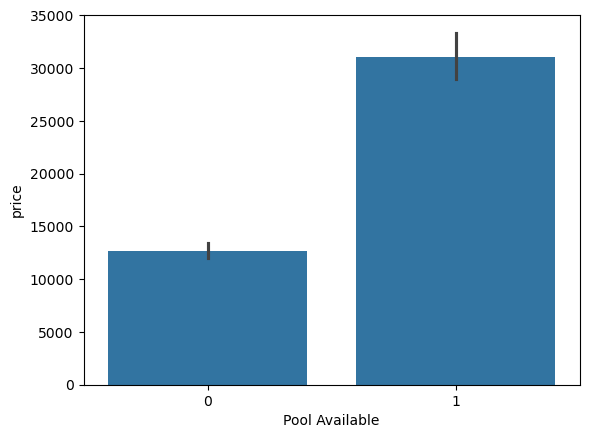

In [284]:
sns.barplot(final_df, y = 'price', x = 'Pool Available')
plt.show()

- **Conclusions**
    - The price of the listings shows much variation based on pool availability, suggesting that pool availability significantly affect the price.

<h2> Feature Engineering </h1>

<h5> Handling Missing Data <h5>

In [285]:
simple_imputer = SimpleImputer(strategy='median')
final_df['rating'] = simple_imputer.fit_transform(final_df[['rating']])

<h5> Mathematical Transformations <h5>

In [286]:
log_transform = FunctionTransformer(func=np.log1p)

final_df['price'] = log_transform.fit_transform(final_df['price'])
final_df['reviews'] = log_transform.fit_transform(final_df['reviews'])

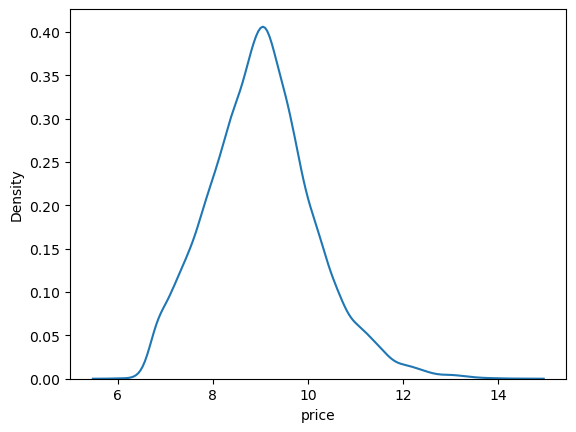

In [287]:
sns.kdeplot(final_df, x= 'price')
plt.show()

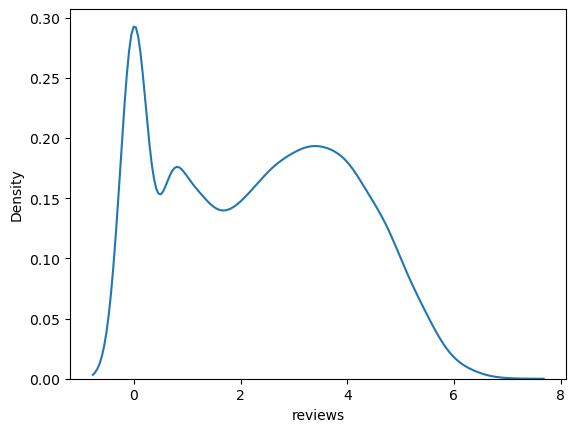

In [288]:
sns.kdeplot(final_df, x= 'reviews')
plt.show()

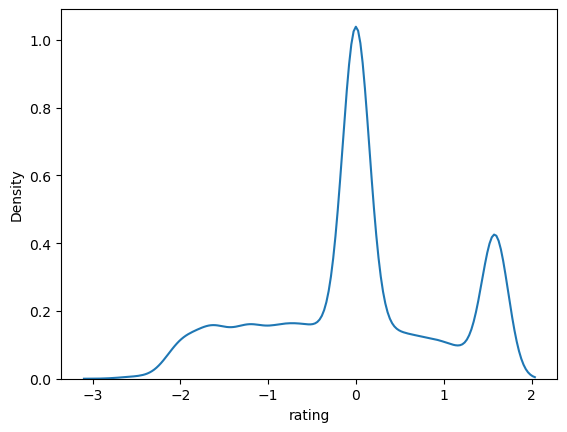

In [289]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

final_df['rating'] = pt.fit_transform(final_df[['rating']])

sns.kdeplot(final_df, x= 'rating')
plt.show()

<h5> Feature Scaling <h5>

In [290]:
standard_scaling = StandardScaler()

final_df['reviews'] = standard_scaling.fit_transform(final_df[['reviews']]).ravel()
final_df['price'] = standard_scaling.fit_transform(final_df[['price']]).ravel()

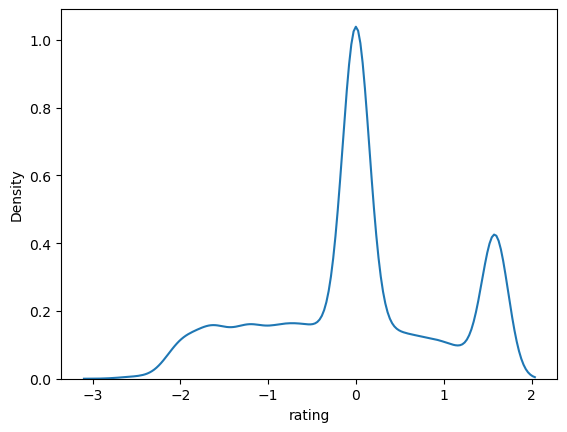

In [291]:
sns.kdeplot(final_df, x = 'rating')
plt.show()

<h5> Outliers Handling <h5>

In [292]:
px.box(final_df, x = 'rating')

In [293]:
len(final_df['rating'][final_df['rating'] < -2.221784])

42

In [294]:
final_df['rating'] = np.where(final_df['rating'] < -2.221784, -2.221784, final_df['rating'])

In [295]:
px.box(final_df, x = 'rating')

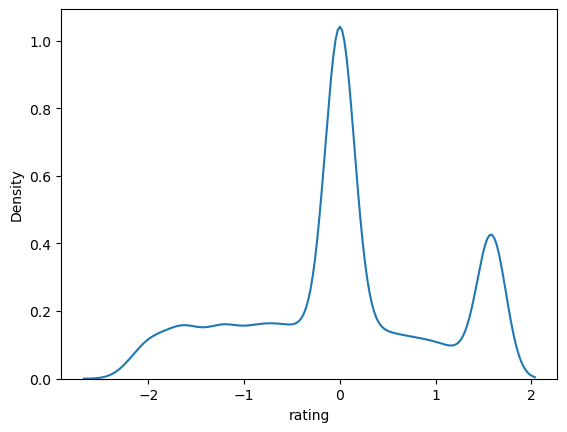

In [296]:
sns.kdeplot(final_df, x = 'rating')
plt.show()

In [297]:
px.box(final_df, x = 'reviews')

In [298]:
px.box(final_df, x = 'price')

The outliers on the right refer to the luxury listings, but listings with a price >= 4.019 refer to those which are luxury listings with an unusually high listed price. Therefore, we can consider them as outliers. Additionally, the two data points on the left can also be considered outliers.

In [299]:
final_df[(final_df['price'] >= 4.019) | (final_df['price'] < -2.395)]

rating   reviews     price  guest_allowed  No_of_bedrooms  \
200   -0.219101  1.107455 -2.395099              2               4   
3071  -0.000349 -0.735978 -2.761414              4               1   
4259  -0.000349 -1.378928 -2.615619              0               1   
4488  -0.000349 -1.378928  4.904489              1               5   
4529  -0.000349 -1.378928  4.237661              8               4   
4585  -0.000349 -1.378928  4.053068              1               8   
4844   0.924451  0.861740  4.501648              2               1   
7078  -0.000349 -1.378928  4.019693              1               5   
10827 -0.000349 -1.378928  4.282140              1               1   
10928 -0.000349 -1.378928  4.108098              1               1   
11076 -0.000349 -1.378928  4.482024              1               1   
11122 -0.000349 -1.378928  4.087140              1               1   

       No_of_beds  No of Bathrooms  Wi-Fi Available  Television Available  \
200             4                4                1                     0   
3071            1                1                1                     1   
4259            1                1                1                     1   
4488            5                5                1                     1   
4529            4                4                1                     1   
4585            8                9                1                     1   
4844            1                1                0                     0   
7078            5                5                1                     1   
10827           1                2                1                     0   
10928           1                1                1                     1   
11076           1                1                1                     1   
11122           1                8                1                     1   

       Refrigerator Available  Scenic Views  Parking Available  Pool Available  
200                         0             0                  0               0  
3071                        0             0                  1               0  
4259                        0             0                  1               0  
4488                        0             0                  0               0  
4529                        0             0                  0               0  
4585                        0             0                  1               1  
4844                        1             0                  1               0  
7078                        0             0                  0               1  
10827                       0             0                  1               1  
10928                       0             0                  1               1  
11076                       0             0                  0               1  
11122                       0             0                  1               1

In [300]:
final_df['price'] = np.where(final_df['price'] >= 4.019, 3.91, np.where(final_df['price'] < -2.395, -2.395, final_df['price']))

In [301]:
px.box(final_df, x = 'price')

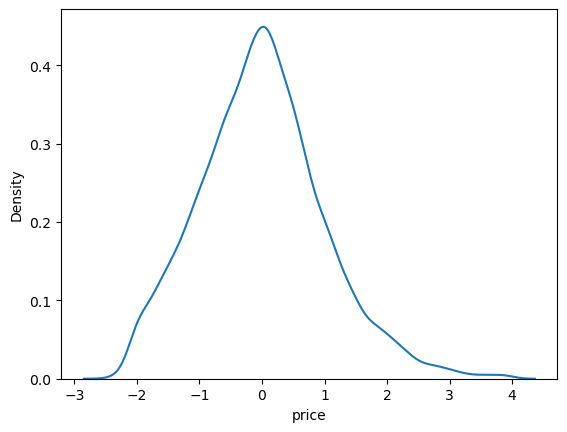

In [302]:
sns.kdeplot(final_df, x='price')
plt.show()

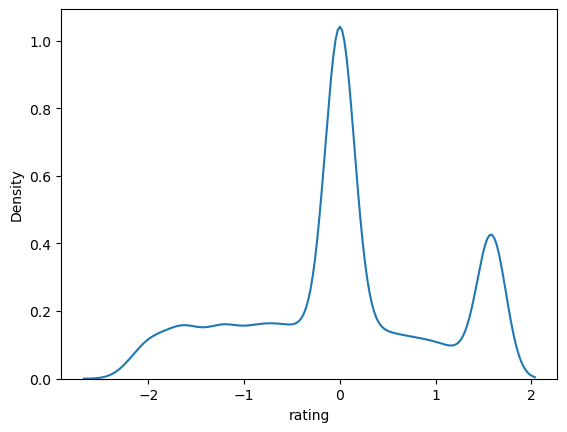

In [303]:
sns.kdeplot(final_df, x= 'rating')
plt.show()

<h4> Model Training <h4>

In [304]:
X = final_df.drop(['price'], axis=1)
y = final_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2)

In [305]:
model = Sequential()

model.add(Input(shape=(12,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [306]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               1664      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
Total params: 10,185
Trainable params: 10,185
Non-trainable params: 0
_________________________________________________________________


In [307]:
cback = EarlyStopping(
    monitor = "val_loss",                  # Defines quantity to be monitored 
    min_delta = 0.00001,                   # Minimum change in the monitored data to qualify as an improvement
    patience = 10,                         # No. of epochs with no improvement afte which training will be stopped.    
    verbose = 1,                           # Displays callback messages
    mode = "auto",# {"auto", "min", "max"} # Always opt for auto, its intelligence will take "max" or "min" automatically. 
    baseline = None,
    restore_best_weights = True
)

In [308]:
history_base = model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), callbacks=cback)

Epoch 1/500
81/81 [==============================] - 2s 15ms/step - loss: 0.8907 - mse: 0.8907 - val_loss: 0.8317 - val_mse: 0.8317
Epoch 2/500
81/81 [==============================] - 1s 9ms/step - loss: 0.7667 - mse: 0.7667 - val_loss: 0.7341 - val_mse: 0.7341
Epoch 3/500
81/81 [==============================] - 1s 9ms/step - loss: 0.7180 - mse: 0.7180 - val_loss: 0.7095 - val_mse: 0.7095
Epoch 4/500
81/81 [==============================] - 1s 9ms/step - loss: 0.6974 - mse: 0.6974 - val_loss: 0.7144 - val_mse: 0.7144
Epoch 5/500
81/81 [==============================] - 1s 9ms/step - loss: 0.6806 - mse: 0.6806 - val_loss: 0.7013 - val_mse: 0.7013
Epoch 6/500
81/81 [==============================] - 1s 9ms/step - loss: 0.6666 - mse: 0.6666 - val_loss: 0.7030 - val_mse: 0.7030
Epoch 7/500
81/81 [==============================] - 1s 9ms/step - loss: 0.6556 - mse: 0.6556 - val_loss: 0.6791 - val_mse: 0.6791
Epoch 8/500
81/81 [==============================] - 1s 9ms/step - loss: 0.6439 - 

ANN after Hyperparameter Tuning

In [309]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Input(shape=(12, )))

    num_layers = hp.Int('num_layers', 1, 7)
        
    for i in range(num_layers):
        num_nodes = hp.Choice(f'num_nodes_{i}', [16, 32, 64, 128, 256])
        l2_value = hp.Choice('l2_regularization', [0.001, 0.01, 0.1])
        
        model.add(Dense(num_nodes, activation='relu', kernel_regularizer=l2(l2_value)))
    
    model.add(Dense(1, activation='linear'))

    optimizer = hp.Choice('optimizer', values=['rmsprop', 'adam', 'nadam', 'adadelta'])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
    return model

In [310]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    directory = 'direc',
    project_name = 'project'
)

In [311]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 07s]
val_mse: 0.7947317957878113

Best val_mse So Far: 0.6981551647186279
Total elapsed time: 00h 01m 06s


In [312]:
best_model_hyperparameter = tuner.get_best_hyperparameters()[0].values
best_model_hyperparameter

{'num_layers': 3,
 'num_nodes_0': 64,
 'l2_regularization': 0.001,
 'optimizer': 'adam',
 'num_nodes_1': 256,
 'num_nodes_2': 32,
 'num_nodes_3': 64,
 'num_nodes_4': 16,
 'num_nodes_5': 128,
 'num_nodes_6': 32}

In [313]:
best_model = tuner.get_best_models(num_models=1)[0]
print(best_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 25,729
Trainable params: 25,729
Non-trainable params: 0
_________________________________________________________________
None


In [314]:
history_tuned = best_model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), callbacks = cback)

Epoch 1/500
81/81 [==============================] - 2s 12ms/step - loss: 0.7629 - mse: 0.6720 - val_loss: 0.7766 - val_mse: 0.6872
Epoch 2/500
81/81 [==============================] - 1s 9ms/step - loss: 0.7529 - mse: 0.6649 - val_loss: 0.7768 - val_mse: 0.6900
Epoch 3/500
81/81 [==============================] - 1s 9ms/step - loss: 0.7348 - mse: 0.6493 - val_loss: 0.7718 - val_mse: 0.6872
Epoch 4/500
81/81 [==============================] - 1s 9ms/step - loss: 0.7315 - mse: 0.6481 - val_loss: 0.8131 - val_mse: 0.7306
Epoch 5/500
81/81 [==============================] - 1s 10ms/step - loss: 0.7226 - mse: 0.6406 - val_loss: 0.7647 - val_mse: 0.6837
Epoch 6/500
81/81 [==============================] - 1s 9ms/step - loss: 0.7083 - mse: 0.6279 - val_loss: 0.7616 - val_mse: 0.6821
Epoch 7/500
81/81 [==============================] - 1s 12ms/step - loss: 0.6994 - mse: 0.6206 - val_loss: 0.7549 - val_mse: 0.6769
Epoch 8/500
81/81 [==============================] - 1s 14ms/step - loss: 0.7026

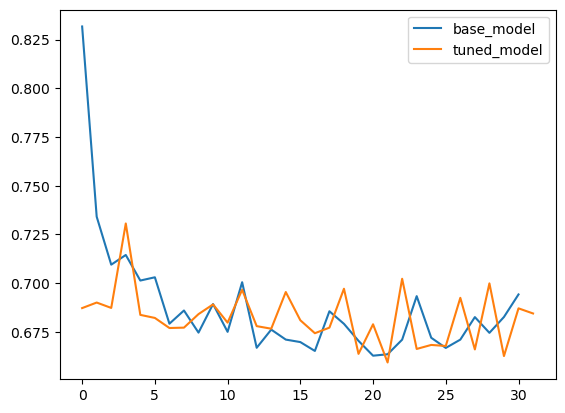

In [336]:
plt.plot(history_base.history['val_mse'], label='base_model')
plt.plot(history_tuned.history['val_mse'], label='tuned_model')
plt.legend()
plt.show()